In [12]:
#plot the Losses vs epochs
import torch
import torch.nn.functional as F
from torchvision.models import inception_v3
from torchvision.transforms import functional as TF
import seaborn as sns
import pandas as pd
import numpy as np
from AC_GAN.models_and_tools.ACGAN_paper import *
from AC_GAN.models_and_tools.functions import *

device = 'cuda'

In [13]:

def inception_score(images, cuda=True, batch_size=32, resize=False, splits=10):
    """计算 Inception Score.
    参数:
    - images: PyTorch tensor, 大小 [N, 3, H, W]
    - cuda: 是否使用 GPU
    - batch_size: 处理图片的批次大小
    - resize: 是否调整图片为 (299, 299)
    - splits: 计算分数时数据集分割的数量
    """
    N = len(images)
    assert batch_size > 0
    assert N > batch_size

    # 加载 Inception 模型
    inception_model = inception_v3(pretrained=True, transform_input=False)
    inception_model.eval()
    if cuda:
        inception_model.cuda()

    def get_pred(x):
        if resize:
            x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
        with torch.no_grad():
            x = inception_model(x)
        return F.softmax(x, dim=1).data.cpu().numpy()

    # 计算预测和边缘分布
    preds = np.zeros((N, 1000))

    for i in range(0, N, batch_size):
        batch = images[i:i + batch_size]
        if cuda:
            batch = batch.cuda()
        batch_pred = get_pred(batch)
        preds[i:i + batch_size] = batch_pred

    # 分割数据，计算 Inception Score
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k + 1) * (N // splits), :]
        p_y = np.expand_dims(np.mean(part, axis=0), 0)
        kl_div = part * (np.log(part + 1e-10) - np.log(p_y + 1e-10))
        kl_div = np.mean(np.sum(kl_div, axis=1))
        split_scores.append(np.exp(kl_div))

    return split_scores

# 用法示例
# 假设 `generated_images` 是你的生成图片数据, 形状 [N, 3, H, W]
# is_mean, is_std = inception_score(generated_images, cuda=True, resize=True, batch_size=32)

In [14]:
netG = Generator(conf).to(device)
# netD = Discriminator(conf).to(device)
# Load the weights back into the models
netG.load_state_dict(torch.load('netG200.pth'))
# netD.load_state_dict(torch.load('netD200.pth'))
# Make sure to call eval() if you're in inference mode
netG.eval()
# netD.eval()
netGp = GeneratorP(conf).to(device)
# netDp = DiscriminatorP(conf).to(device)
# Load the weights back into the models
netGp.load_state_dict(torch.load('netGr.pth'))
# netDp.load_state_dict(torch.load('netDr.pth'))
# Make sure to call eval() if you're in inference mode
netGp.eval()
# netDp.eval()

GeneratorP(
  (linear): Sequential(
    (0): Linear(in_features=110, out_features=6144, bias=True)
    (1): ReLU(inplace=True)
  )
  (main): Sequential(
    (0): ConvTranspose2d(384, 192, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(192, 96, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (4): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(96, 3, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (7): Tanh()
  )
)

In [15]:


num_images = 500
fake_labels = torch.randint(0, conf.num_classes, (num_images,), device=device)
fake_images = generate_images(netG, num_images, fake_labels)

In [16]:
score1 = inception_score(fake_images, cuda=True, resize=True, batch_size=10)
# print("Inception Score:", is_mean)

C:\Users\Cmex-\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Cmex-\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
num_images = 500
fake_labels = torch.randint(0, conf.num_classes, (num_images,), device=device)
fake_imagesP = generate_images(netGp, num_images, fake_labels)

In [37]:
score2 = inception_score(fake_imagesP, cuda=True, resize=True, batch_size=10)
# print("Inception Score:", is_mean)


C:\Users\Cmex-\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Cmex-\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


NameError: name 'scoreGAN' is not defined

In [53]:

scoreGAN = [2.179886016195921, 1.9081686821218027, 2.4893287135328466, 2.2958862399454296, 2.065903260770452, 2.3191262662626704, 2.0532378287360977, 1.9892835140630758, 2.7940876879705905, 2.373729993533359]
scoreWGAN = [2.118968851889485, 1.8600999999033445, 2.702729415967596, 2.4793129250691766, 2.165253393869036, 2.535138410691615, 2.000657093331701, 2.0068096778203097, 2.8736124451438565, 2.5871782902363787]

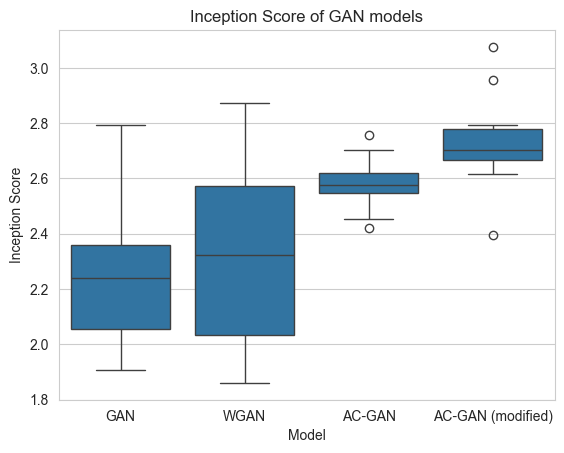

In [52]:

# Create a DataFrame
df = pd.DataFrame({'GAN': scoreGAN, 'WGAN': scoreWGAN, 'AC-GAN': np.array(score2), 'AC-GAN (modified)': np.array(score1)})
# Melt the DataFrame to long-format
df_long = pd.melt(df, var_name='Model', value_name='Inception Score')
# Create a box plot
sns.boxplot(x='Model', y='Inception Score', data=df_long)
# Optional: Add a title
plt.title('Inception Score of GAN models')

# Show the plot
plt.show()